Now for this figure, we want to characterize the folds better.

In [1]:
import importlib
import os

if importlib.util.find_spec('asilib') is None:
    !pip install asilib
import numpy as np
print(np.__version__)
if int(np.__version__[0]) > 1:
  os.kill(os.getpid(), 9) #asilib requires numpy 1.26, but the cloud initially
  #forced to numpy 2.0, to fix this we kill it THIS REQUIRES YOU TO RUN TWICE

for pkg in ['scienceplots', 'viresclient', 'geopack']:
  if importlib.util.find_spec(pkg) is None:
      !pip install {pkg}

1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.0/114.0 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp
import scienceplots
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

from geopy.distance import geodesic
plt.style.use(['science','no-latex'])
import pandas as pd
alt=150

Load IGRF coefficients ...


In [3]:
time_array=(datetime(2022,12,19,14,2), datetime(2022,12,19,14,8))

Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing

Lets define the imager

In [4]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt,   time_range=time_array, colors='r')


Downloaded 20221219_1402_yknf_rgb-08_full.h5.
Downloaded 20221219_1403_yknf_rgb-08_full.h5.
Downloaded 20221219_1404_yknf_rgb-08_full.h5.
Downloaded 20221219_1405_yknf_rgb-08_full.h5.
Downloaded 20221219_1406_yknf_rgb-08_full.h5.
Downloaded 20221219_1407_yknf_rgb-08_full.h5.
Downloaded rgb_skymap_yknf_20220913-%2B_v01.sav.
Downloaded rgb_skymap_yknf_20230114-%2B_v01.sav.
Downloaded rgb_skymap_yknf_20230327-%2B_v01.sav.
Downloaded rgb_skymap_yknf_20240327-%2B_v01.sav.
Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Spac

Now lets look at images and define some lines for ewograms

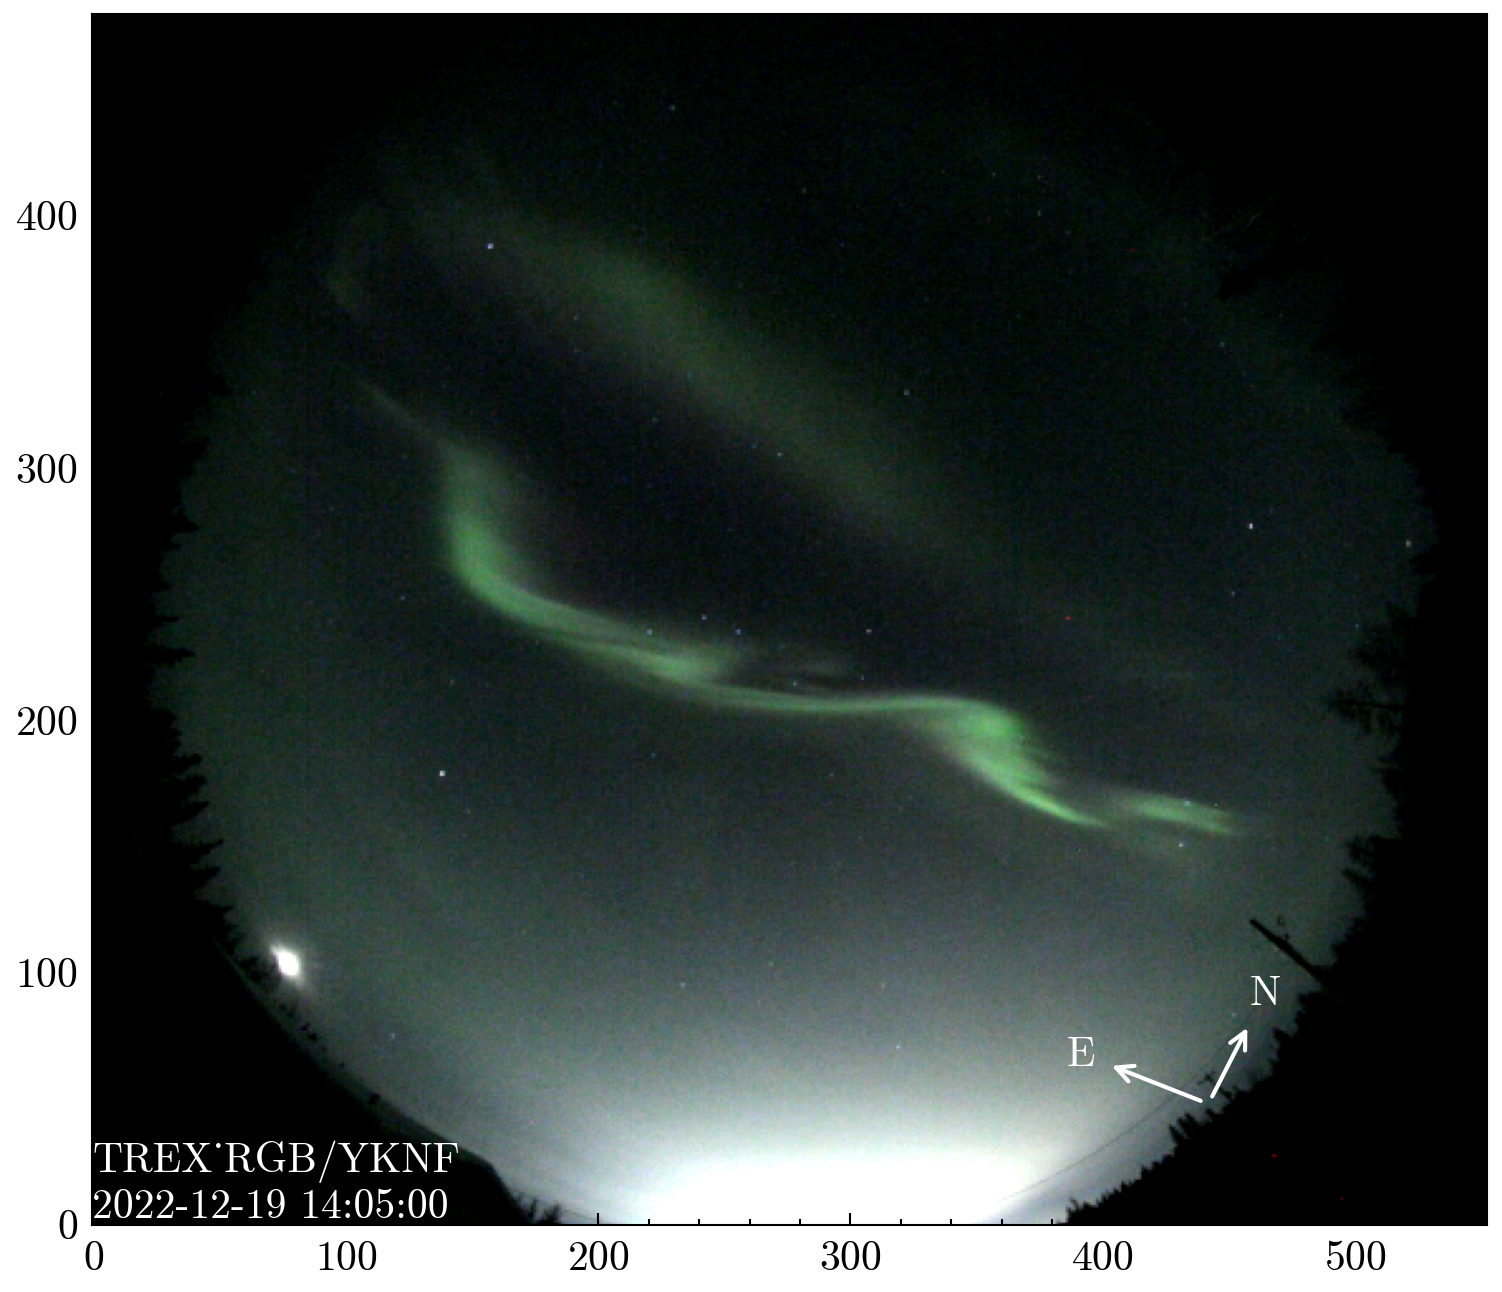

In [5]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
from datetime import datetime
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=alt,  time=datetime(2022,12,19,14,5), colors='rgb')

ax, im_good = asi_single.plot_fisheye(ax=ax)


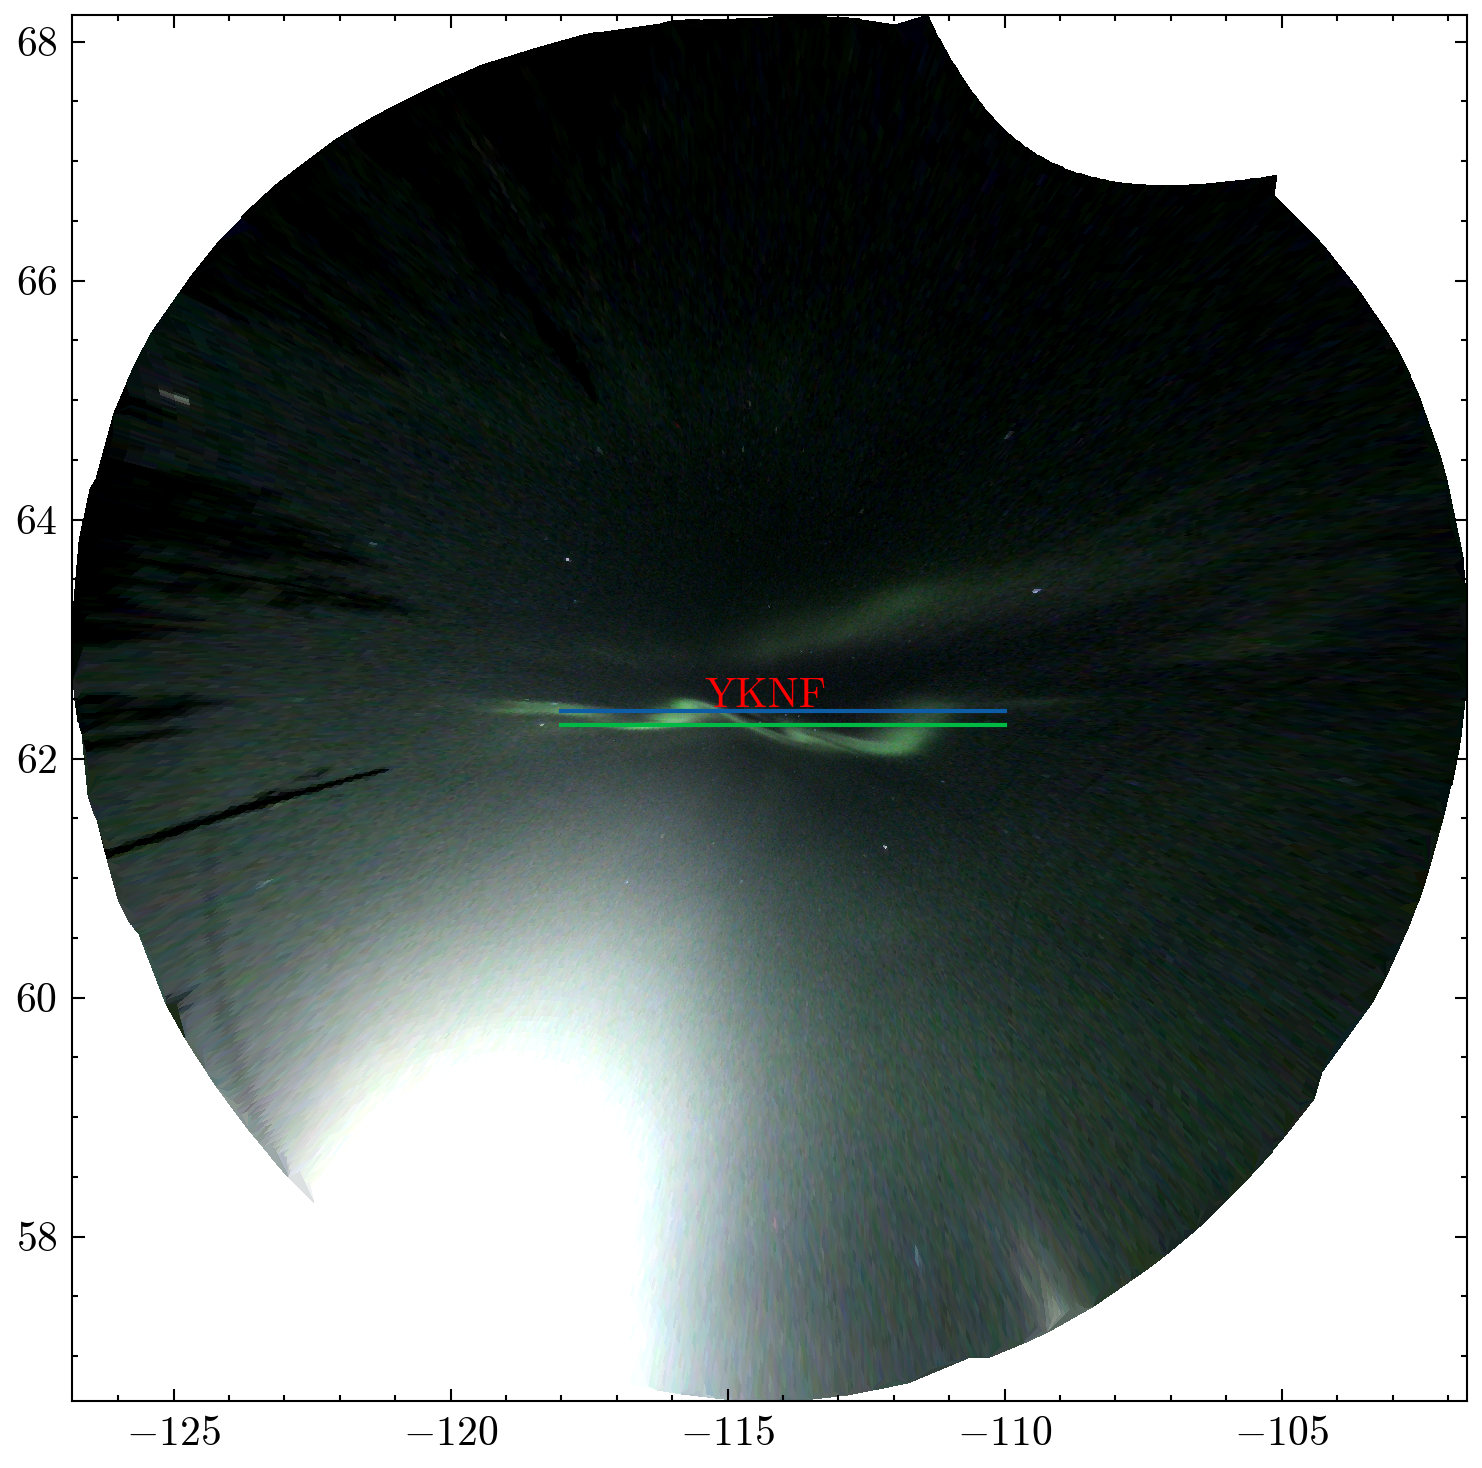

In [6]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax, im_good = asi_single.plot_map(ax=ax)
coords=im_good.get_coordinates()
x_coords=coords[:,:,0]
y_coords=coords[:,:,1]
x = np.linspace(-118, -110, 200)
y= np.linspace(62.4, 62.4, 200)
plt.plot(x,y)
y= np.linspace(62.28, 62.28, 200)
plt.plot(x,y)




In [7]:


# grid_lats, grid_lons: 2D arrays representing the latitude and longitude grid
# line_lats, line_lons: 1D arrays representing the latitude and longitude of the line

def find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons):
    # Reshape line_lats and line_lons for broadcasting with the grid
    line_lats_reshaped = line_lats[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)
    line_lons_reshaped = line_lons[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)

    # Compute squared Euclidean distances using broadcasting
    lat_diff = grid_lats[np.newaxis, :, :] - line_lats_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    lon_diff = grid_lons[np.newaxis, :, :] - line_lons_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    distances = lat_diff**2 + lon_diff**2  # Shape: (num_points, grid_lat_dim, grid_lon_dim)

    # Find the flat index of the minimum distance for each point along the grid axes
    min_indices_flat = np.argmin(distances.reshape(distances.shape[0], -1), axis=1)  # Shape: (num_points,)

    # Convert flat indices back to 2D grid indices for all points at once
    grid_shape = grid_lats.shape
    closest_indices = np.stack(np.unravel_index(min_indices_flat, grid_shape), axis=1)

    return closest_indices.T

# Example usage
grid_lats = np.array(y_coords)  # Replace y_coords with the actual grid latitude array (2D)
grid_lons = np.array(x_coords)  # Replace x_coords with the actual grid longitude array (2D)

line_lats = np.array(y)         # Replace y with the actual line latitude array (1D)
line_lons = np.array(x)         # Replace x with the actual line longitude array (1D)

closest_indices = find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons)


2022-12-19 14:02:00 2022-12-19 14:08:00


NameError: name 'j' is not defined

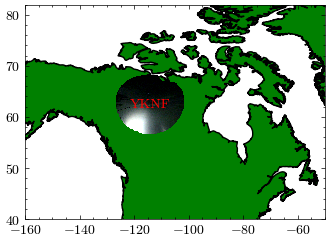

In [8]:
import numpy as np
# Define the coordinates for y values
x_1 = np.linspace(-119, -107, 500)  # x-coordinates (longitude range)
y_values = [62.25]  # y-values for different lines (latitude)
y_target = np.array([62.25]*500)  # 2D array of shape (4, 800)
print(time_array[0], time_array[-1])
# Initialize ASI object
asi = asilib.asi.trex_rgb(location_code='yknf', alt=alt ,  time_range=(time_array[0], time_array[-1]))

# Lists to hold results
pixel_closest_list = np.zeros((120, 500, 3), dtype=np.uint8)
time_ewo = []

movie_generator = asi.animate_map_gen()
closest_indices = []
for i, (time, image, _, im) in enumerate(movie_generator):
    if i ==0:
        coords = im.get_coordinates()
        grid_lons = coords[:, :, 0]
        grid_lats = coords[:, :, 1]
        # Loop over each y-value target line
        # Get closest grid points for all 800 points on the line
        closest_indices = find_closest_grid_points(grid_lats, grid_lons, y_target, x_1)

        # Ensure closest_indices has shape (800, 2) where 800 points correspond to x_1
        # closest_indices[0] = indices of closest grid points for latitudes
        # closest_indices[1] = indices of closest grid points for longitudes

        if closest_indices.shape[0] == 500:
            # Fetch the RGB values for all 800 closest grid points using advanced indexing
            pixel_values = image[closest_indices[:, 0], closest_indices[:, 1], :]  # shape (800, 3)

            # Append all pixel values for this y-value line
            pixel_closest_list[i] = pixel_values
        else:
            print(f"Error: closest_indices does not match the expected shape for y_value index")
    else:
        # Get closest grid points for all 800 points on the line

        # Ensure closest_indices has shape (800, 2) where 800 points correspond to x_1
        # closest_indices[0] = indices of closest grid points for latitudes
        # closest_indices[1] = indices of closest grid points for longitudes

        if closest_indices.shape[0] == 500:
            # Fetch the RGB values for all 800 closest grid points using advanced indexing
            pixel_values = image[closest_indices[:, 0], closest_indices[:, 1], :]  # shape (800, 3)

            # Append all pixel values for this y-value line
            pixel_closest_list[i] = pixel_values



    time_ewo.append(time)
    if i==119: #due to an ffmpeg error associated with this code, not intended use.
        break



In [ ]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300, tight_layout=True)

# Plot the data
ax.pcolormesh( x_1,time_ewo, pixel_closest_32[:,:,1], vmin=10, vmax=70)
start_datetime = pd.Timestamp('2022-12-19 14:06')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.6
end_longitude = -114
plt.ylim(pd.Timestamp('2022-12-19 14:03'), pd.Timestamp('2022-12-19 14:07.30'))
ax.tick_params(axis='both', colors='white', labelcolor='black', which='both')
plt.title(r"Ewogram at constant geographic latitude $\theta= 62.25^{\circ}$")




# Set titles and labels
fig.supylabel(r"Time (H:M)", fontsize=9)  # X label closer to bottom
fig.supxlabel(r"Geographic Longitude", fontsize=9)  # Y label closer to left


In [ ]:
start_time= datetime(2022,12,19,14,5,3)
time_array= [start_time + timedelta(seconds=3*x) for x in range(16)]


fig, axes = plt.subplots(figsize=(10,8), nrows=4, ncols=4, dpi=300, sharex=True, sharey=True, tight_layout=True)

axlist=axes.flatten()

for i in range(len(time_array)):
    axlist[i].tick_params(axis='both', colors='white', labelcolor='black', which='both')
    asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=time_array[i], colors='rgb')

    asi.plot_map(ax=axlist[i], asi_label=False)
    axlist[i].set_title(time_array[i].strftime('%H:%M:%S%f')[:-6])
    axlist[i].set_xlim(-117,-113)
    axlist[i].set_ylim(62.1,62.5)
fig.suptitle("Track of Swarm B Over Auroral Vortices")
fig.supxlabel("Geographic Longitude", y=0.02)
fig.supylabel("Geographic Latitude")



In [ ]:
start_time= datetime(2022,12,19,14,5,3)
time_array= [start_time + timedelta(seconds=6*x) for x in range(8)]


fig, axes = plt.subplots(figsize=(10,8), nrows=4, ncols=2, dpi=300, sharex=True, sharey=True, tight_layout=True)

axlist=axes.flatten()

for i in range(len(time_array)):
    axlist[i].tick_params(axis='both', colors='white', labelcolor='black', which='both')
    asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=time_array[i], colors='rgb')

    asi.plot_map(ax=axlist[i], asi_label=False)
    axlist[i].set_title(time_array[i].strftime('%H:%M:%S%f')[:-6])
    axlist[i].set_xlim(-117,-113)
    axlist[i].set_ylim(62.1,62.5)
fig.suptitle("Track of Swarm B Over Auroral Vortices")
fig.supxlabel("Geographic Longitude", y=0.02)
fig.supylabel("Geographic Latitude")



In [ ]:



fig= plt.figure(figsize=(10,12), dpi=300)
gs = gridspec.GridSpec(4, 3, figure=fig,width_ratios=[1,1,1.1], wspace=0.1)  # 3 rows, 4 columns for flexibility

# Left column: Spanning all 3 rows
axewo = fig.add_subplot(gs[:, 2])  # Entire left column

axewo.tick_params(axis='both', colors='white', labelcolor='black')
im = axewo.pcolormesh( x_1,time_ewo, pixel_closest_32[:,:,1], vmin=10, vmax=70)
start_datetime = pd.Timestamp('2022-12-19 14:06')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)
start_longitude = -116.2
end_longitude = -113.9
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)
axewo.set_ylim(pd.Timestamp('2022-12-19 14:04:30'), pd.Timestamp('2022-12-19 14:06:45'))
axewo.tick_params(axis='both', colors='white', labelcolor='black', which='both')
axewo.set_title(r"Ewogram at constant latitude $\theta= 62.25^{\circ}$")
locator = mdates.SecondLocator(interval=15)  # Shows every minute
formatter = mdates.DateFormatter('%M:%S')
axewo.set_xlim(-117,-111)


axewo.yaxis.set_major_locator(locator)
axewo.yaxis.set_major_formatter(formatter)
axewo.tick_params(axis='y', rotation=0)
pos = axewo.get_position()

# Create new axes for colorbar: same height, but narrow width
cbar_width = 0.02  # This controls how thin the colorbar is
cbar_padding = 0.06  # Space between plot and colorbar

cbar_ax = fig.add_axes([
    pos.x1 + cbar_padding,  # x-position (right of main plot)
    pos.y0,                 # y-position (same as main plot)
    cbar_width,             # width (THIN!)
    pos.height              # height (same as main plot)
])

# Create the colorbar in that axis
cbar= fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Green Pixel Intensity", rotation=270, labelpad=12.5)
axlist = [fig.add_subplot(gs[x, y]) for x in range(4) for y in range(2)]

for i in range(len(time_array)):
    axlist[i].tick_params(axis='both', colors='white', labelcolor='black', which='both')
    asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt, time=time_array[i], colors='rgb')

    asi.plot_map(ax=axlist[i], asi_label=False, )
    axlist[i].axhline(y=62.25, color='white', linestyle='--', dashes=(5, 15))
    axlist[i].set_title(time_array[i].strftime('%H:%M:%S%f')[:-6])
    axlist[i].set_xlim(-117,-111)
    axlist[i].set_ylim(62,62.5)
    if i==0 or i==2 or i==4: #logic for labels, some down need to be shown
        plt.setp(axlist[i].get_xticklabels(), visible=False)
    elif i==7:
        plt.setp(axlist[i].get_yticklabels(), visible=False)
    elif i==6:
        pass
    else:
        plt.setp(axlist[i].get_xticklabels(), visible=False)
        plt.setp(axlist[i].get_yticklabels(), visible=False)

fig.supxlabel("Geographic Longitude", y=0.07)
fig.supylabel("Geographic Latitude", x=0.07)

longitude_values = np.linspace(start_longitude, end_longitude, num=100)
axewo.plot( longitude_values, date_range, color='white', linestyle='--', dashes=(5, 15))

coord1 = (62.25, start_longitude)
coord2 = (62.25, end_longitude )
distance = geodesic(coord1, coord2).kilometers
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
axewo.set_ylabel("Time M:S", fontsize=12)
fig.suptitle("Analysis of Folds", y=0.92)
fig.text(0.1, 0.905, "a)", fontsize=13, fontweight='bold', va='top', ha='left')
fig.text(0.64, 0.905, "b)",  fontsize=13, fontweight='bold', va='top', ha='left')
pos = axewo.get_position()  # Get the original position
axewo.set_position([pos.x0 + 0.04, pos.y0, pos.width, pos.height])  # Shift right by 0.03

longitude_values = np.linspace(-116.6, -115.5, num=100)
start_datetime = pd.Timestamp('2022-12-19 14:05:00')
end_datetime = pd.Timestamp('2022-12-19 14:05:35')
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

axewo.plot( longitude_values, date_range, color='white', linestyle='--', dashes=(5, 15))
coord1 = (62.25, start_longitude)
coord2 = (62.25, end_longitude )
distance = geodesic(coord1, coord2).kilometers
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")









start_longitude=-112.8
end_longitude=-111.8
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
start_datetime = pd.Timestamp('2022-12-19 14:05:37')
end_datetime = pd.Timestamp('2022-12-19 14:05:47')
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

axewo.plot( longitude_values, date_range, color='white', linestyle='--', dashes=(5, 15))
coord1 = (62.25, start_longitude)
coord2 = (62.25, end_longitude )
distance = geodesic(coord1, coord2).kilometers
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")


start_longitude=-114.1
end_longitude=-113.8
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
start_datetime = pd.Timestamp('2022-12-19 14:05:20')
end_datetime = pd.Timestamp('2022-12-19 14:05:35')
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

axewo.plot( longitude_values, date_range, color='white', linestyle='--', dashes=(5, 15))
coord1 = (62.25, start_longitude)
coord2 = (62.25, end_longitude )
distance = geodesic(coord1, coord2).kilometers
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")


start_longitude=-114.35
end_longitude=-114.2
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
start_datetime = pd.Timestamp('2022-12-19 14:05:20')
end_datetime = pd.Timestamp('2022-12-19 14:05:35')
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

axewo.plot( longitude_values, date_range, color='white', linestyle='--', dashes=(5, 15))
coord1 = (62.25, start_longitude)
coord2 = (62.25, end_longitude )
distance = geodesic(coord1, coord2).kilometers
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")


start_longitude=-114.6
end_longitude=-114.8
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
start_datetime = pd.Timestamp('2022-12-19 14:05:20')
end_datetime = pd.Timestamp('2022-12-19 14:05:35')
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

axewo.plot( longitude_values, date_range, color='white', linestyle='--', dashes=(5, 15))
coord1 = (62.25, start_longitude)
coord2 = (62.25, end_longitude )
distance = geodesic(coord1, coord2).kilometers
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")


